# References

### [sklearn]
- https://www.kaggle.com/mchirico/quick-look-seaborn-wordcloud
- https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

### [pytorch]
- https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from io import StringIO
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, minmax_scale
from text_processing import text_preprocessing
from wordcloud import WordCloud

# Data Preparation

- train-test split
- batch-loading
- data preparation for MIMIC from postgres
- null handling = sMOTE or other conventional methods
- auxilliary data for netflix needs to be collected

![](static/privacygan_titatic_preprocessing.png)

### Dataset 01: Titanic
- source: https://www.kaggle.com/c/titanic/data
- predict the survival based on passenger information

In [3]:
df_data = pd.read_csv('data/titanic.csv')
len_prev = len(df_data)
df_data.drop(['Cabin'], axis=1, inplace=True)
df_data.dropna(inplace=True)
len_curr = len(df_data)
print("{} rows with null values dropped".format(len_prev-len_curr))
print("{} rows of data available".format(len_curr))
df_data.head(3)

179 rows with null values dropped
712 rows of data available


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S


### Text Preprocessing
- making text case insensitive
- handling special characters
- can possibly help match more columns in case of noisy data 
- standardize the categorical columns to prevent more dummy variables.

In [4]:
for col in ['Name', 'Sex', 'Embarked', 'Ticket']:
    df_data[col+'_preprocessed'] = list(map(text_preprocessing, df_data[col].tolist()))
df_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Name_preprocessed,Sex_preprocessed,Embarked_preprocessed,Ticket_preprocessed
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,braund mr owen harris,male,s,a 5 21171
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,cumings mrs john bradley florence briggs thayer,female,c,pc 17599
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,heikkinen miss laina,female,s,ston o2 3101282


### Visualizations

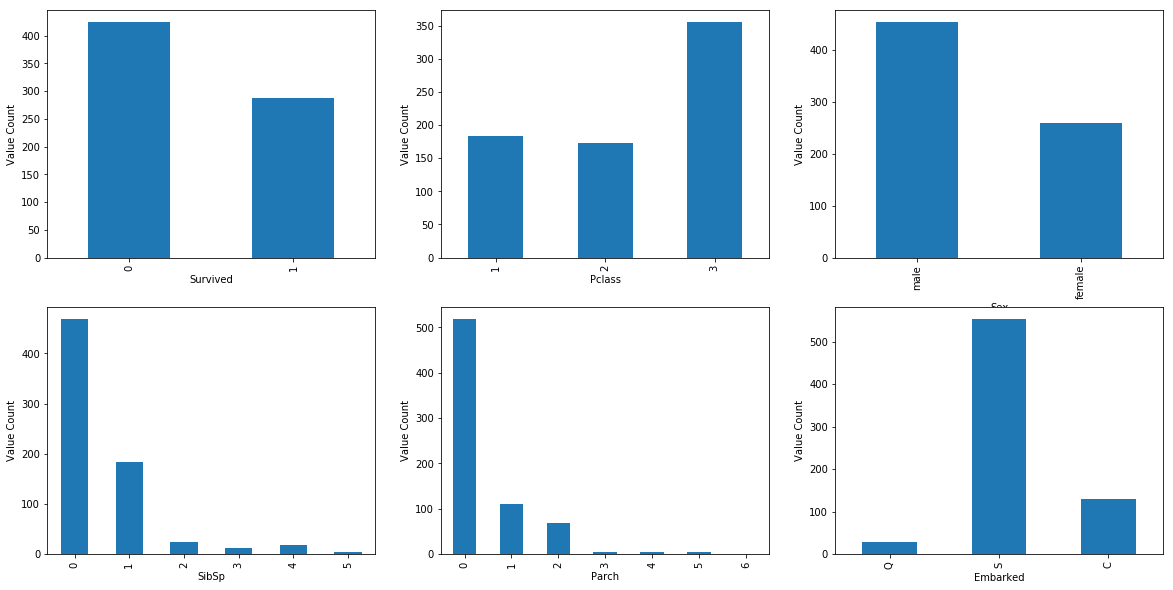

In [5]:
categorical_columns = [
    'Survived', 
    'Pclass', 
    'Sex', 
    'SibSp', 
    'Parch', 
    'Embarked'
]

num_cols = 3
num_rows = math.ceil(len(categorical_columns)/3)

plt.figure(figsize=(20, 5*num_rows))

for col in range(len(categorical_columns)):    
    plt.subplot(num_rows, num_cols, col+1)
    df_data[categorical_columns[col]].value_counts(sort=False).plot(kind='bar')
    plt.xlabel(categorical_columns[col])
    plt.ylabel('Value Count')
plt.show()

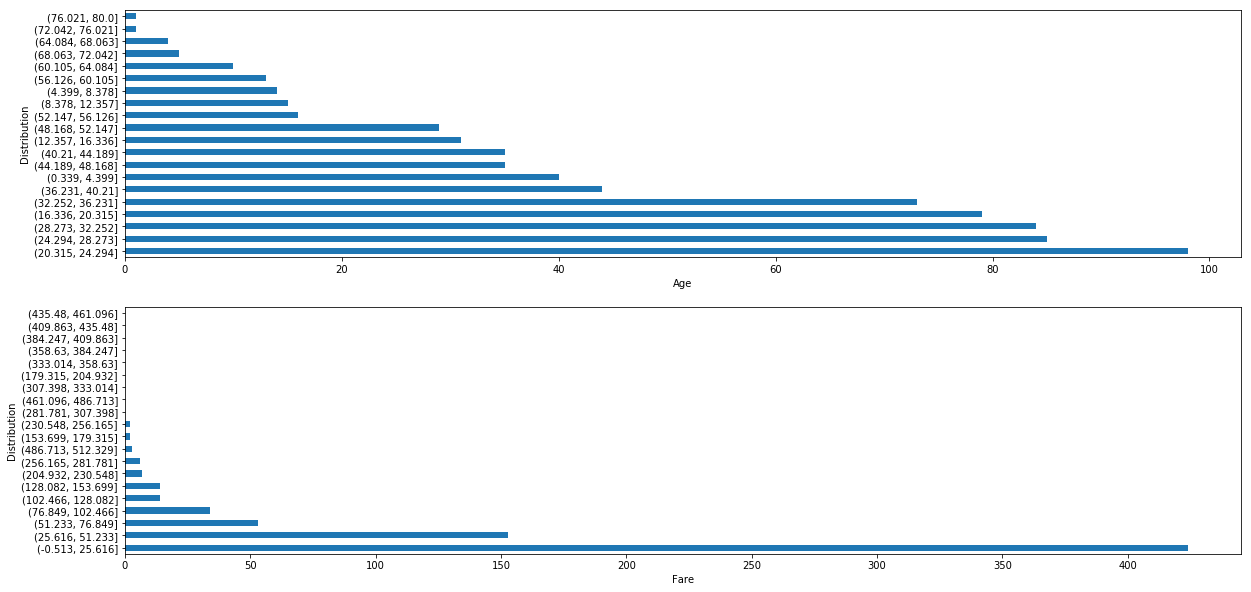

In [6]:
continuous_variables = [
    'Age', 
    'Fare'
]

num_cols = 1
num_rows = math.ceil(len(categorical_columns)/3)

plt.figure(figsize=(20, 5*num_rows))

for col in range(len(continuous_variables)):    
    plt.subplot(num_rows, num_cols, col+1)
    df_data[continuous_variables[col]].value_counts(bins=20, sort=True).plot(kind='barh')
    plt.xlabel(continuous_variables[col])
    plt.ylabel('Distribution')
plt.show()


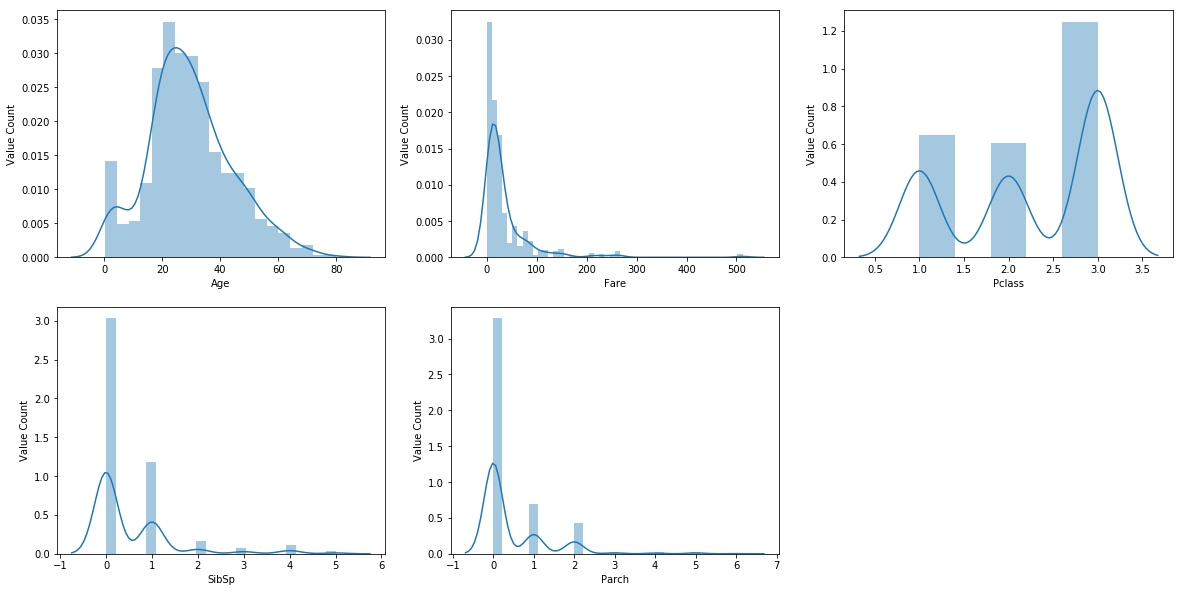

In [7]:
dist_columns = [
    'Age',
    'Fare',
    'Pclass',
    'SibSp',
    'Parch'
]

num_cols = 3
num_rows = math.ceil(len(dist_columns)/3)

plt.figure(figsize=(20, 5*num_rows))

for col in range(len(dist_columns)):    
    plt.subplot(num_rows, num_cols, col+1)
    sns.distplot(df_data[dist_columns[col]])
    plt.xlabel(dist_columns[col])
    plt.ylabel('Value Count')
plt.show()

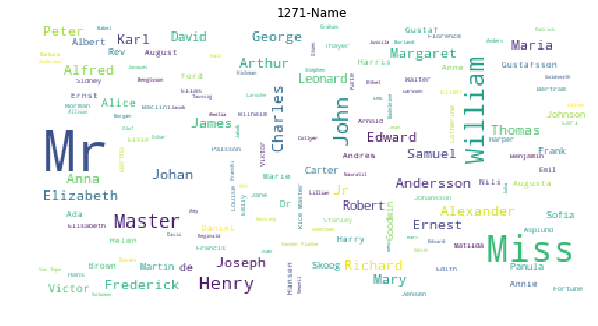

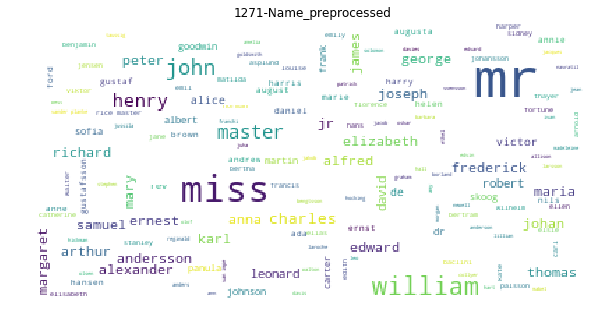

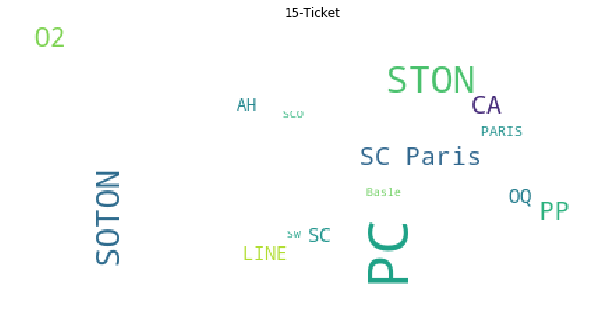

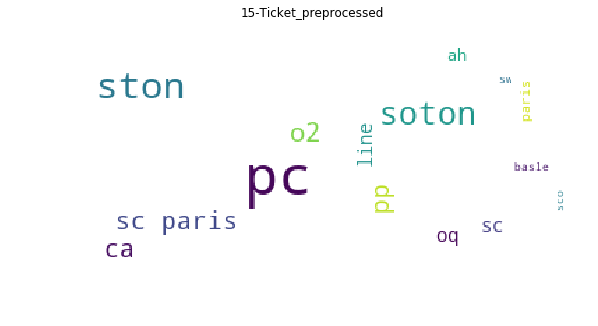

In [8]:
text_columns = ['Name', 'Name_preprocessed', 'Ticket', 'Ticket_preprocessed']

for col in range(len(text_columns)):
    si=StringIO()
    df_data[text_columns[col]].apply(lambda x: si.write(str(x) + " "))
    text=si.getvalue()
    si.close()

    wordcloud = WordCloud(width=1600, height=1600, max_words=100).generate(text)
    wordcloud = WordCloud(
        background_color="white",
        max_words=len(text),
        max_font_size=40, 
        relative_scaling=.5
    ).generate(text)
    plt.figure(figsize=(10, 20))
    plt.imshow(wordcloud)
    plt.title("{}-{}".format(str(len(wordcloud.words_)), text_columns[col]))
    plt.axis("off")
    plt.show()

### Definition of Ally and Adversary Variables.
- Ally target: Survived
- Adversary target: Sex
- The choice of adversary target can be changed.
- Chosen M/F here as it will be possible to have train-test split or k-fold validation

In [9]:
for col in ["Name", "Sex", "Embarked", "Ticket"]:
    df_data[col] = df_data[col+"_preprocessed"]
    df_data.drop([col+"_preprocessed"], axis=1, inplace=True)
df_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,braund mr owen harris,male,22.0,1,0,a 5 21171,7.2500,s
1,2,1,1,cumings mrs john bradley florence briggs thayer,female,38.0,1,0,pc 17599,71.2833,c
2,3,1,3,heikkinen miss laina,female,26.0,0,0,ston o2 3101282,7.9250,s


In [10]:
df_data = pd.get_dummies(df_data, columns=['Sex'], drop_first=True)
df_data = pd.get_dummies(df_data, columns=['Pclass', 'SibSp', 'Parch', 'Embarked'])
df_data.head()

,PassengerId,Survived,Name,Age,Ticket,Fare,Sex_male,Pclass_1,Pclass_2,Pclass_3,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_c,Embarked_q,Embarked_s
0,1,0,braund mr owen harris,22.0,a 5 21171,7.2500,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,2,1,cumings mrs john bradley florence briggs thayer,38.0,pc 17599,71.2833,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,3,1,heikkinen miss laina,26.0,ston o2 3101282,7.9250,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,4,1,futrelle mrs jacques heath lily may peel,35.0,113803,53.1000,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,5,0,allen mr william henry,35.0,373450,8.0500,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1


In [11]:
y_ally = np.array(df_data.Survived.tolist())
y_advr = np.array(df_data.Sex_male.tolist())

df_data.drop(['Survived', 'Sex_male'], axis=1, inplace=True)

- using One hot encoding to convert the categorical data into dummy variables.
- Alternatively: [Managing categorical variables in pandas dataframe](http://benalexkeen.com/mapping-categorical-data-in-pandas/)
- Using count vectorizer to convert the text data into features based on bow model.

In [12]:
vectorizer = CountVectorizer()
Name = vectorizer.fit_transform(df_data.Name.tolist()).toarray()
vectorizer = CountVectorizer(vocabulary=wordcloud.words_.keys())
Ticket = vectorizer.fit_transform(df_data.Ticket.tolist()).toarray()

In [13]:
df_data.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
df_data.head(3)

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_c,Embarked_q,Embarked_s
0,22.0,7.2500,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,26.0,7.9250,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [14]:
X = np.concatenate((df_data.values, Name, Ticket), axis=1)
y_ally.shape, y_advr.shape, X.shape

((712,), (712,), (712, 1324))

### Train Test Split

- This step is required before the Scaling or PCA is learnt on the train dataset and then used to transform the test dataset.

In [15]:
X_train, X_valid, y_ally_train, y_ally_valid, y_advr_train, y_advr_valid = train_test_split(
    X, 
    y_ally,
    y_advr,
    test_size=0.1,
    stratify=pd.DataFrame(np.concatenate((y_ally.reshape(-1, 1), y_advr.reshape(-1, 1)), axis=1))
)
X_train.shape, X_valid.shape, y_ally_train.shape, y_ally_valid.shape, y_advr_train.shape, y_advr_valid.shape

((640, 1324), (72, 1324), (640,), (72,), (640,), (72,))

### Checking the distribution after the split

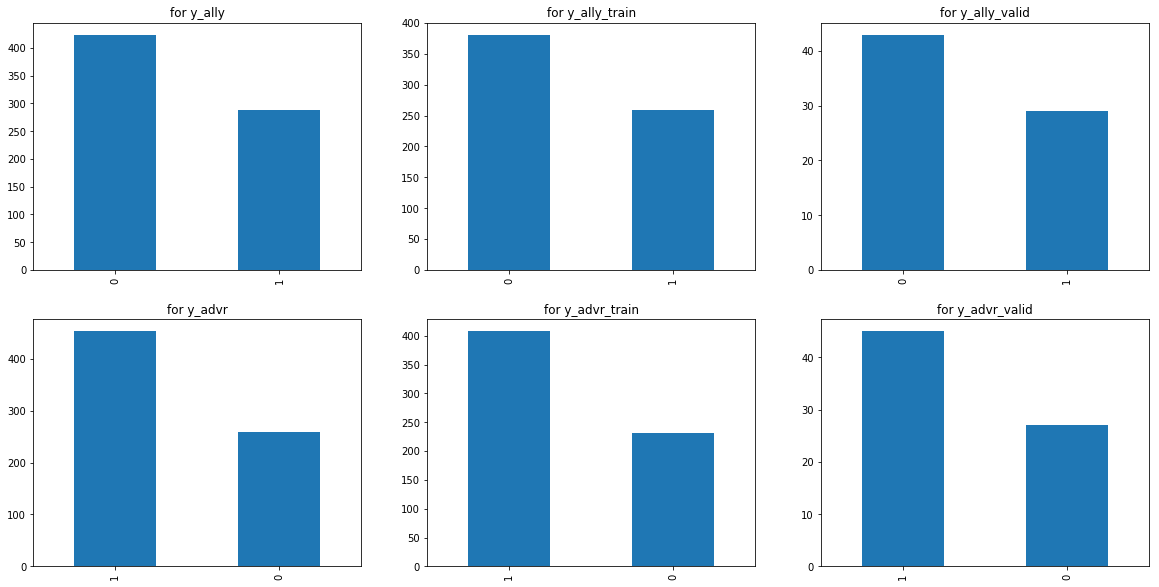

In [16]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
pd.value_counts(y_ally).plot(kind='bar')
plt.title('for y_ally')
plt.subplot(2, 3, 2)
pd.value_counts(y_ally_train).plot(kind='bar')
plt.title('for y_ally_train')
plt.subplot(2, 3, 3)
pd.value_counts(y_ally_valid).plot(kind='bar')
plt.title('for y_ally_valid')
plt.subplot(2, 3, 4)
pd.value_counts(y_advr).plot(kind='bar')
plt.title('for y_advr')
plt.subplot(2, 3, 5)
pd.value_counts(y_advr_train).plot(kind='bar')
plt.title('for y_advr_train')
plt.subplot(2, 3, 6)
pd.value_counts(y_advr_valid).plot(kind='bar')
plt.title('for y_advr_valid')
plt.show()

### Scaler
- Perform minmax scaling for removing the skewness which might effect the gradient descent during neural network training. 
- It is necessary to do this scaling before PCA is applied

In [17]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_valid_normalized = scaler.transform(X_valid)

![](static/privacygan_titanic_experiment.png)

### Apply PCA and select components using explained variances

In [18]:
pca = PCA()
X_train_reduced = pca.fit_transform(X_train_normalized)

In [19]:
num_components = 0
total_var = 0
variance_threshold = 0.99
for _ in pca.explained_variance_ratio_:
    total_var += _
    num_components += 1
    if total_var > variance_threshold:
        break
print(total_var, num_components)

0.9900276863189008 590


In [20]:
pca = PCA(n_components=num_components)
X_train_reduced = pca.fit_transform(X_train_normalized)
X_valid_reduced = pca.transform(X_valid_normalized)
X_train_reduced.shape, X_valid_reduced.shape

((640, 590), (72, 590))

### Apply Auto-encoder for dimensionality reduction

![](static/privacygan_titanic_autoencoder.png)

In [21]:
import torch
import torch.utils.data as utils
import torch.nn as nn

In [22]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print("DType: {}\nCuda available: {}\nDevice: {}".format(
    dtype.__str__(),
    torch.cuda.is_available().__str__(),
    device.__str__(),
))

X_train_torch = torch.Tensor(X_train_normalized).to(device)
X_valid_torch = torch.Tensor(X_valid_normalized).to(device)
y_ally_train_torch = torch.Tensor(y_ally_train.reshape(-1, 1)).to(device)
y_ally_valid_torch = torch.Tensor(y_ally_valid.reshape(-1, 1)).to(device)
y_advr_train_torch = torch.Tensor(y_advr_train.reshape(-1, 1)).to(device)
y_advr_valid_torch = torch.Tensor(y_advr_valid.reshape(-1, 1)).to(device)

DType: torch.float32
Cuda available: True
Device: cuda


In [23]:
X_train_torch.shape, X_valid_torch.shape, \
y_ally_train_torch.shape, y_ally_valid_torch.shape, \
y_advr_train_torch.shape, y_advr_valid_torch.shape

(torch.Size([640, 1324]),
 torch.Size([72, 1324]),
 torch.Size([640, 1]),
 torch.Size([72, 1]),
 torch.Size([640, 1]),
 torch.Size([72, 1]))

In [24]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.input_size = input_size
        self.encoding_dim = encoding_dim
        
        self.fc1 = torch.nn.Linear(self.input_size, self.encoding_dim)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.encoding_dim, self.input_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def encoder(self, x):
        return self.relu(self.fc1(x))

    def decoder(self, y):
        return self.sigmoid(self.fc2(y))
    
    def forward(self, x):
        y = self.encoder(x)
        x = self.decoder(y)
        return x

In [32]:
auto_encoder = AutoEncoder(input_size=X_train.shape[1],encoding_dim=X_train_reduced.shape[1]).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
ae_optimizer = optimizer(auto_encoder.parameters(), lr = 0.001)

In [33]:
print("epoch \t Aencoder_train \t Aencoder_valid")

ae_epoch = []
ae_train = []
ae_valid = []

for epoch in range(501):
    auto_encoder.train()
    ae_optimizer.zero_grad()
    
    X_train_torch_hat = auto_encoder(X_train_torch)
    ae_loss = criterion(X_train_torch_hat, X_train_torch)
    ae_loss.backward(retain_graph=True)
    ae_optimizer.step()
    
    if epoch%50!=0:
        continue
        
    auto_encoder.eval()
    
    X_valid_torch_hat = auto_encoder(X_valid_torch)
    ae_valid_loss = criterion(X_valid_torch_hat, X_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        ae_loss.item(),
        ae_valid_loss
    ))
    ae_epoch.append(epoch)
    ae_train.append(ae_loss.item())
    ae_valid.append(ae_valid_loss)

epoch 	 Aencoder_train 	 Aencoder_valid
0 	 0.97423065 	 0.97128630
50 	 0.68147910 	 0.69596410
100 	 0.67527395 	 0.69363219
150 	 0.67175478 	 0.69099271
200 	 0.66983235 	 0.68959457
250 	 0.66862530 	 0.68852091
300 	 0.66779250 	 0.68782592
350 	 0.66687644 	 0.68722492
400 	 0.66619778 	 0.68648601
450 	 0.66564995 	 0.68562514
500 	 0.66511410 	 0.68530136


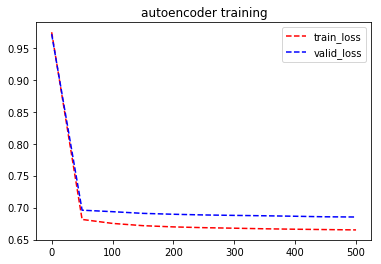

In [34]:
plt.plot(ae_epoch, ae_train, 'r--')
plt.plot(ae_epoch, ae_valid, 'b--')
plt.legend(['train_loss', 'valid_loss'])
plt.title("autoencoder training")
plt.show()

In [35]:
auto_encoder.eval()
X_train_torch_ae = auto_encoder.encoder(X_train_torch)
X_valid_torch_ae = auto_encoder.encoder(X_valid_torch)
X_train_torch_ae.shape, X_valid_torch_ae.shape

(torch.Size([640, 590]), torch.Size([72, 590]))

# GAN using Pytorch

- ["**Learning Informative and Private Representations via Generative Adversarial Networks**"](http://www.princeton.edu/~pmittal/publications/gan-bigdata18.pdf)

![](static/privacygan_titanic_privacygan.png)

### GAN V1

```python
encd_N = 64 
encd_D_in = X.shape[1]
encd_H = int(encd_D_in/2)
encd_D_out = 64

# encoder
encd_w1 = torch.randn(encd_D_in, encd_H, device=device, dtype=dtype, requires_grad=True)
encd_w2 = torch.randn(encd_H, encd_D_out, device=device, dtype=dtype, requires_grad=True)

ally_N = 64 
ally_D_in = encd_D_out
ally_H = int(ally_D_in/2)
ally_D_out = 1

# ally
ally_w1 = torch.randn(ally_D_in, ally_H, device=device, dtype=dtype, requires_grad=True)
ally_w2 = torch.randn(ally_H, ally_D_out, device=device, dtype=dtype, requires_grad=True)

advr_N = 64 
advr_D_in = encd_D_out
advr_H = int(advr_D_in/2)
advr_D_out = 2

# advr
advr_w1 = torch.randn(advr_D_in, advr_H, device=device, dtype=dtype, requires_grad=True)
advr_w2 = torch.randn(advr_H, advr_D_out, device=device, dtype=dtype, requires_grad=True)
```

### GAN V2

In [36]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Ally(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Ally, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Adversary(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Adversary, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [37]:
alpha = 0.5

In [42]:
encoding_dimension = X_train_reduced.shape[1]
encoder = Encoder(input_size=X_train_torch.shape[1], hidden_size=1024, output_size=encoding_dimension).cuda()
ally = Ally(input_size=encoding_dimension, hidden_size=128, output_size=y_ally_train_torch.shape[1]).cuda()
adversary = Adversary(input_size=encoding_dimension, hidden_size=128, output_size=y_advr_train_torch.shape[1]).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
encd_optimizer = optimizer(encoder.parameters(), lr = 0.001)
ally_optimizer = optimizer(ally.parameters(), lr=0.00001)
advr_optimizer = optimizer(adversary.parameters(), lr=0.01)

In [43]:
print("epoch \t encoder_train \t encoder_valid \t ally_train \t ally_valid \t advr_train \t advr_valid")

g_epoch = []
enc_train = []
enc_valid = []
ally_train = []
ally_valid = []
advr_train = []
advr_valid = []

for epoch in range(501):
    # set for training
    encoder.train()
    ally.train()
    adversary.train()
    
    encd_optimizer.zero_grad()
    # Forward passv
    X_train_encoding = encoder(X_train_torch)
    y_ally_train_torch_hat = ally(X_train_encoding)
    y_advr_train_torch_hat = adversary(X_train_encoding)
    # Compute Loss
    ally_loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    advr_loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    encd_loss = alpha * ally_loss - (1-alpha) * advr_loss
    # Backward pass
    encd_loss.backward(retain_graph=True)
    encd_optimizer.step()

    for i in range(10):
        ally_optimizer.zero_grad()
        advr_optimizer.zero_grad()

        X_train_encoding = encoder(X_train_torch)
        y_ally_train_torch_hat = ally(X_train_encoding)
        y_advr_train_torch_hat = adversary(X_train_encoding)
        
        ally_loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
        advr_loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
        
        ally_loss.backward(retain_graph=True)
        advr_loss.backward(retain_graph=True)

        ally_optimizer.step()
        advr_optimizer.step()
        
    if epoch%50!=0:
        continue

    # set for eval
    encoder.eval()
    ally.eval()
    adversary.eval()
    
    X_valid_encoding = encoder(X_valid_torch)
    y_ally_valid_torch_hat = ally(X_valid_encoding)
    y_advr_valid_torch_hat = adversary(X_valid_encoding)

    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    encd_valid_loss = alpha * ally_loss - ((1-alpha) * advr_loss)
        
    print('{} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        encd_loss.item(),
        encd_valid_loss,
        ally_loss.item(), 
        ally_valid_loss,
        advr_loss.item(),
        advr_valid_loss,
    ))
    
    g_epoch.append(epoch)
    enc_train.append(encd_loss.item())
    enc_valid.append(encd_valid_loss)
    ally_train.append(ally_loss.item())
    ally_valid.append(ally_valid_loss)
    advr_train.append(advr_loss.item())
    advr_valid.append(advr_valid_loss)

epoch 	 encoder_train 	 encoder_valid 	 ally_train 	 ally_valid 	 advr_train 	 advr_valid
0 	 0.05720812 	 0.05385235 	 0.75656730 	 0.76269162 	 0.64886260 	 0.65820986
50 	 -0.04187301 	 -0.04387984 	 0.60539097 	 0.71043980 	 0.69315064 	 0.69314808
100 	 -0.07559681 	 -0.07563534 	 0.54187649 	 0.69228804 	 0.69314718 	 0.69314718
150 	 -0.07643470 	 -0.07644108 	 0.54026502 	 0.68765485 	 0.69314718 	 0.69314718
200 	 -0.07665008 	 -0.07665238 	 0.53984243 	 0.68485373 	 0.69314718 	 0.69314718
250 	 -0.07673907 	 -0.07674018 	 0.53966683 	 0.68256253 	 0.69314718 	 0.69314718
300 	 -0.07678527 	 -0.07678589 	 0.53957540 	 0.68086940 	 0.69314718 	 0.69314718
350 	 -0.07681218 	 -0.07681254 	 0.53952211 	 0.67959100 	 0.69314718 	 0.69314718
400 	 -0.07682905 	 -0.07682928 	 0.53948861 	 0.67854470 	 0.69314718 	 0.69314718
450 	 -0.07684016 	 -0.07684031 	 0.53946656 	 0.67767149 	 0.69314718 	 0.69314718
500 	 -0.07684773 	 -0.07684782 	 0.53945154 	 0.67692238 	 0.69314718 	 0.

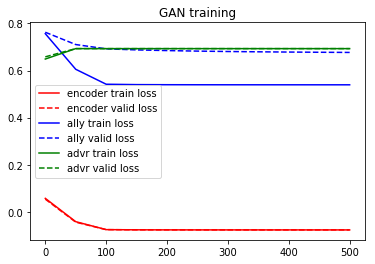

In [57]:
plt.plot(g_epoch, enc_train, 'r')
plt.plot(g_epoch, enc_valid, 'r--')
plt.plot(g_epoch, ally_train, 'b')
plt.plot(g_epoch, ally_valid, 'b--')
plt.plot(g_epoch, advr_train, 'g')
plt.plot(g_epoch, advr_valid, 'g--')
plt.legend([
    'encoder train loss', 
    'encoder valid loss',
    'ally train loss',
    'ally valid loss',
    'advr train loss',
    'advr valid loss'
])
plt.title("GAN training")
plt.show()

# Ally and Adversary Learning on Encoded Data

In [47]:
X_train_encoded = encoder(X_train_torch)
X_valid_encoded = encoder(X_valid_torch)
X_train_encoded.shape, X_valid_encoded.shape

(torch.Size([640, 590]), torch.Size([72, 590]))

In [48]:
X_train_reduced.shape, X_valid_reduced.shape

((640, 590), (72, 590))

In [49]:
y_ally_train_torch.shape, y_ally_valid_torch.shape

(torch.Size([640, 1]), torch.Size([72, 1]))

In [50]:
class Network(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Network, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.sigmoid(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [51]:
lr = 0.001

network = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

n_epoch = []
train = []
valid = []
for epoch in range(501):
    network.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network(X_train_encoded)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network.eval()
    y_ally_valid_torch_hat = network(X_valid_encoded)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))
    
    n_epoch.append(epoch)
    train.append(loss.item())
    valid.append(ally_valid_loss)

epoch 	 ally_train 	 ally_valid
0 	 0.77574944 	 0.75883806
50 	 0.54499912 	 0.67152065
100 	 0.54188699 	 0.66762424
150 	 0.54090196 	 0.66587514
200 	 0.54043001 	 0.66485327
250 	 0.54016131 	 0.66416651
300 	 0.53999168 	 0.66366637
350 	 0.53987658 	 0.66328228
400 	 0.53979439 	 0.66297585
450 	 0.53973323 	 0.66272396
500 	 0.53968638 	 0.66251236


In [52]:
lr = 0.001

network_advr = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

train_a = []
valid_a = []

for epoch in range(501):
    network_advr.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr(X_train_encoded)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr.eval()
    y_advr_valid_torch_hat = network_advr(X_valid_encoded)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    train_a.append(loss.item())
    valid_a.append(advr_valid_loss)

epoch 	 advr_train 	 advr_valid
0 	 0.66087145 	 0.65508121
50 	 0.55738825 	 0.59878719
100 	 0.55669796 	 0.59765607
150 	 0.55645430 	 0.59733033
200 	 0.55633229 	 0.59721071
250 	 0.55626148 	 0.59717423
300 	 0.55621624 	 0.59717613
350 	 0.55618536 	 0.59719700
400 	 0.55616313 	 0.59722739
450 	 0.55614662 	 0.59726274
500 	 0.55613393 	 0.59730035


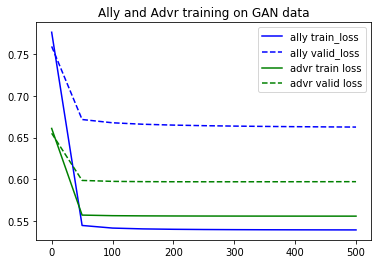

In [56]:
plt.plot(n_epoch, train, 'b')
plt.plot(n_epoch, valid, 'b--')
plt.plot(n_epoch, train_a, 'g')
plt.plot(n_epoch, valid_a, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on GAN data")
plt.show()

# Ally and Adversary Learning on PCA Data

In [58]:
X_train_pca_torch = torch.Tensor(X_train_reduced)
X_valid_pca_torch = torch.Tensor(X_valid_reduced)

In [59]:
lr = 0.01

network_ally_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_pca.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

pca_ally_train = []
pca_ally_valid = []

X_train_pca_torch = X_train_pca_torch.to(device)
X_valid_pca_torch = X_valid_pca_torch.to(device)
y_ally_train_torch = y_ally_train_torch.to(device)
y_ally_valid_torch = y_ally_valid_torch.to(device)

for epoch in range(501):
    network_ally_pca.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network_ally_pca(X_train_pca_torch)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_pca.eval()
    y_ally_valid_torch_hat = network_ally_pca(X_valid_pca_torch)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))
    
    pca_ally_train.append(loss.item())
    pca_ally_valid.append(ally_valid_loss)

epoch 	 ally_train 	 ally_valid
0 	 0.75959760 	 0.71834224
50 	 0.54778939 	 0.63946164
100 	 0.54665273 	 0.63880622
150 	 0.54571098 	 0.63587409
200 	 0.54543120 	 0.63533467
250 	 0.54540491 	 0.63526189
300 	 0.54480565 	 0.63418168
350 	 0.54479182 	 0.63440859
400 	 0.54478407 	 0.63453853
450 	 0.54477924 	 0.63459903
500 	 0.54477590 	 0.63460028


In [60]:
lr = 0.001

network_advr_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_pca.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

y_advr_train_torch = y_advr_train_torch.to(device)
y_advr_valid_torch = y_advr_valid_torch.to(device)

pca_advr_train = []
pca_advr_valid = []

for epoch in range(501):
    network_advr_pca.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr_pca(X_train_pca_torch)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_pca.eval()
    y_advr_valid_torch_hat = network_advr_pca(X_valid_pca_torch)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    
    pca_advr_train.append(loss.item())
    pca_advr_valid.append(advr_valid_loss)

epoch 	 advr_train 	 advr_valid
0 	 0.65555471 	 0.65966946
50 	 0.49421802 	 0.55359274
100 	 0.46339512 	 0.52440780
150 	 0.45982796 	 0.51867580
200 	 0.45870590 	 0.51573974
250 	 0.45817167 	 0.51378679
300 	 0.45786294 	 0.51243126
350 	 0.45764637 	 0.51164800
400 	 0.45705986 	 0.51265091
450 	 0.45688638 	 0.51208055
500 	 0.45680031 	 0.51100147


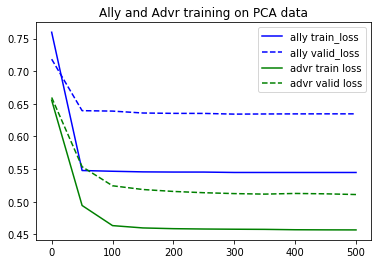

In [62]:
plt.plot(n_epoch, pca_ally_train, 'b')
plt.plot(n_epoch, pca_ally_valid, 'b--')
plt.plot(n_epoch, pca_advr_train, 'g')
plt.plot(n_epoch, pca_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on PCA data")
plt.show()

# Ally and Adversary Training on Auto-encoded data

In [63]:
lr = 0.001

network_ally_ae = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_ae.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

ae_ally_train=[]
ae_ally_valid = []

for epoch in range(501):
    network_ally_ae.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network_ally_ae(X_train_torch_ae)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_ae.eval()
    y_ally_valid_torch_hat = network_ally_ae(X_valid_torch_ae)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))
    
    ae_ally_train.append(loss.item())
    ae_ally_valid.append(ally_valid_loss)

epoch 	 ally_train 	 ally_valid
0 	 0.77286464 	 0.74912804
50 	 0.69432038 	 0.69443411
100 	 0.69374174 	 0.69380617
150 	 0.69348937 	 0.69354659
200 	 0.69335067 	 0.69341016
250 	 0.69326419 	 0.69332945
300 	 0.69320673 	 0.69327825
350 	 0.69316292 	 0.69324237
400 	 0.69311583 	 0.69320923
450 	 0.69306844 	 0.69317979
500 	 0.69298345 	 0.69313556


In [64]:
lr = 0.001

network_advr_ae = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_ae.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

ae_advr_train = []
ae_advr_valid = []

for epoch in range(501):
    network_advr_ae.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr_ae(X_train_torch_ae)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_ae.eval()
    y_advr_valid_torch_hat = network_advr_ae(X_valid_torch_ae)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    
    ae_advr_train.append(loss.item())
    ae_advr_valid.append(advr_valid_loss)

epoch 	 advr_train 	 advr_valid
0 	 0.65565032 	 0.66016573
50 	 0.48236194 	 0.55120224
100 	 0.46059114 	 0.54504746
150 	 0.45733610 	 0.54412967
200 	 0.45631003 	 0.54387528
250 	 0.45583087 	 0.54380780
300 	 0.45556259 	 0.54380405
350 	 0.45539495 	 0.54382473
400 	 0.45528221 	 0.54385579
450 	 0.45520231 	 0.54389161
500 	 0.45514330 	 0.54392940


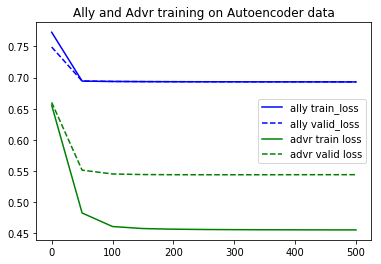

In [66]:
plt.plot(n_epoch, ae_ally_train, 'b')
plt.plot(n_epoch, ae_ally_valid, 'b--')
plt.plot(n_epoch, ae_advr_train, 'g')
plt.plot(n_epoch, ae_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on Autoencoder data")
plt.show()

# Results

| Model | Train Ally  | Valid Ally  | Train Advr | Valid Advr |
|---|---:|---:|---:|---:|
| PCA | 0.54596204 | **0.63508838** | 0.45774460 | 0.47422782 |
| A-Enc | 0.69294691 | 0.69324082 | 0.45286497 | 0.50768989 |
| P-GAN | 0.53968185 | 0.69574529 | 0.45563743 | **0.59513420** |

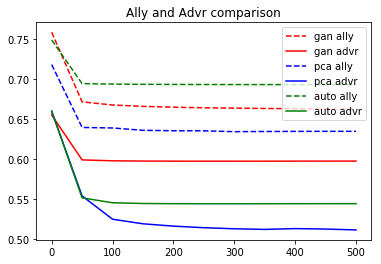

In [67]:
plt.plot(n_epoch, valid, 'r--')
plt.plot(n_epoch, valid_a, 'r')
plt.plot(n_epoch, pca_ally_valid, 'b--')
plt.plot(n_epoch, pca_advr_valid, 'b')
plt.plot(n_epoch, ae_ally_valid, 'g--')
plt.plot(n_epoch, ae_advr_valid, 'g')
plt.legend(['gan ally', 'gan advr', 'pca ally', 'pca advr', 'auto ally', 'auto advr'])
plt.title("Ally and Advr comparison")
plt.show()